In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch
from PFNExperiments.Evaluation.Evaluate import Evaluate
from pyro.infer.autoguide import AutoMultivariateNormal
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC
from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide

from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

from PFNExperiments.LinearRegression.GenerativeModels.TargetScaler import TargetScaler

In [25]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_ExamplesSparsity import make_lm_program_Horseshoe_ig_batched, make_lm_program_Horseshoe_ig

#scaler_pprogram_maker = TargetScaler(transform="standardize")

#make_lm_program = scaler_pprogram_maker.transform_y(make_lm_program_beta_prior)
#make_lm_program_batched = scaler_pprogram_maker.transform_y_batched(make_lm_program_beta_prior_batched)

make_lm_program = make_lm_program_Horseshoe_ig
make_lm_program_batched = make_lm_program_Horseshoe_ig_batched

pprogram_batched = make_lm_program_batched()
pprogram = make_lm_program()


pprogram_y = return_only_y(pprogram)

a = 5.0
b = 2.0


curriculum = Curriculum(max_iter=int(1))
curriculum.add_param_list(
    [
    ("gammma_lambda", curriculum.constant_scheduler(0.1)),
    ("gamma_tausquared", curriculum.constant_scheduler(0.1)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),
    ]
)

"""
curriculum = Curriculum(max_iter=int(1))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(0.1)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),
    ]
)
"""


#gammma_lambda: float = 1.0,
#gamma_tausquared: float = 1.0,
#a: float = 5.0,
#b: float = 2.0


'\ncurriculum = Curriculum(max_iter=int(1))\ncurriculum.add_param_list(\n    [\n    ("tau", curriculum.constant_scheduler(0.1)),\n    ("a", curriculum.constant_scheduler(a)),\n    ("b", curriculum.constant_scheduler(b)),\n    ]\n)\n'

In [26]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_batched,
    curriculum= curriculum,
    #coupling = None
)

In [27]:

"""
data_generator.check_model(
    n_samples_per_epoch=10,
    batch_size=32,
    used_batch_samples=3
    )
"""

'\ndata_generator.check_model(\n    n_samples_per_epoch=10,\n    batch_size=32,\n    used_batch_samples=3\n    )\n'

In [28]:
dataloader_train, dataloader_val, dataloader_test = data_generator.make_dataloaders_for_epoch_dynamic(epoch = 0, n = 100, p = 5, n_samples_per_epoch=100, batch_size=32)

In [29]:
test = next(iter(dataloader_train))

In [30]:
test["y"][1]

tensor([ 0.2449,  0.3706,  0.5315,  0.0209, -0.3699,  0.0778, -0.2222,  0.0238,
        -0.2230,  0.6442,  0.0760, -0.4930,  0.6427, -0.5274, -0.1822, -0.1448,
         0.3008, -0.2765,  0.5040, -0.0743,  0.2916, -0.7180, -1.1015, -0.2436,
         0.9021,  0.1778, -0.0817,  0.2163, -0.0425, -0.2044, -0.5665,  0.4195,
        -0.1870,  0.3849, -0.4489,  0.1456, -0.4559, -0.6307, -0.1384,  0.1539,
         0.5193,  0.1103,  0.0404,  0.1150, -0.1451, -0.0540, -0.0395,  0.3517,
         0.1851, -0.6010, -0.0520, -0.8750,  0.5571, -0.2191,  0.4805,  0.5247,
         0.2346, -1.2047,  0.0295,  0.5852,  0.4864,  0.2600,  0.4161,  0.2861,
        -0.2388,  0.2748,  0.0915,  0.4217, -0.5790, -0.0195, -0.0206, -0.1270,
         0.0051, -0.2239, -0.0717, -0.7148,  0.3970, -0.1520, -0.3861,  0.2117,
         0.0323, -0.5512,  0.7963, -0.0467, -0.1386, -0.5387, -0.0763, -0.5199,
         0.4756, -0.1449, -0.0937, -0.3057,  0.1979,  0.1139, -0.0516,  0.2746,
        -0.5834, -0.7099,  0.7100,  0.16

In [31]:
N_SAMPLES_PER_MODEL = 1000

In [32]:
pprogram = make_lm_program(**data_generator.curriculum.get_params(-1))
pprogram_y = return_only_y(pprogram)


In [33]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

In [34]:
from PFNExperiments.Evaluation.Evaluate import just_return_results, results_dict_to_latent_variable_beta0_and_beta

evaluation = Evaluate(
    posterior_model = hmc_sampler,
    evaluation_loader = dataloader_train,
    comparison_models= [vi_multivariate_normal,
                        ],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_latent_variable_posterior_model=just_return_results,
    results_dict_to_latent_variable_comparison_models=just_return_results,
)

In [35]:
evaluation.run_evaluation()

Warmup:   1%|          | 12/1500 [00:07,  1.07s/it, step size=1.15e-03, acc. prob=0.633]

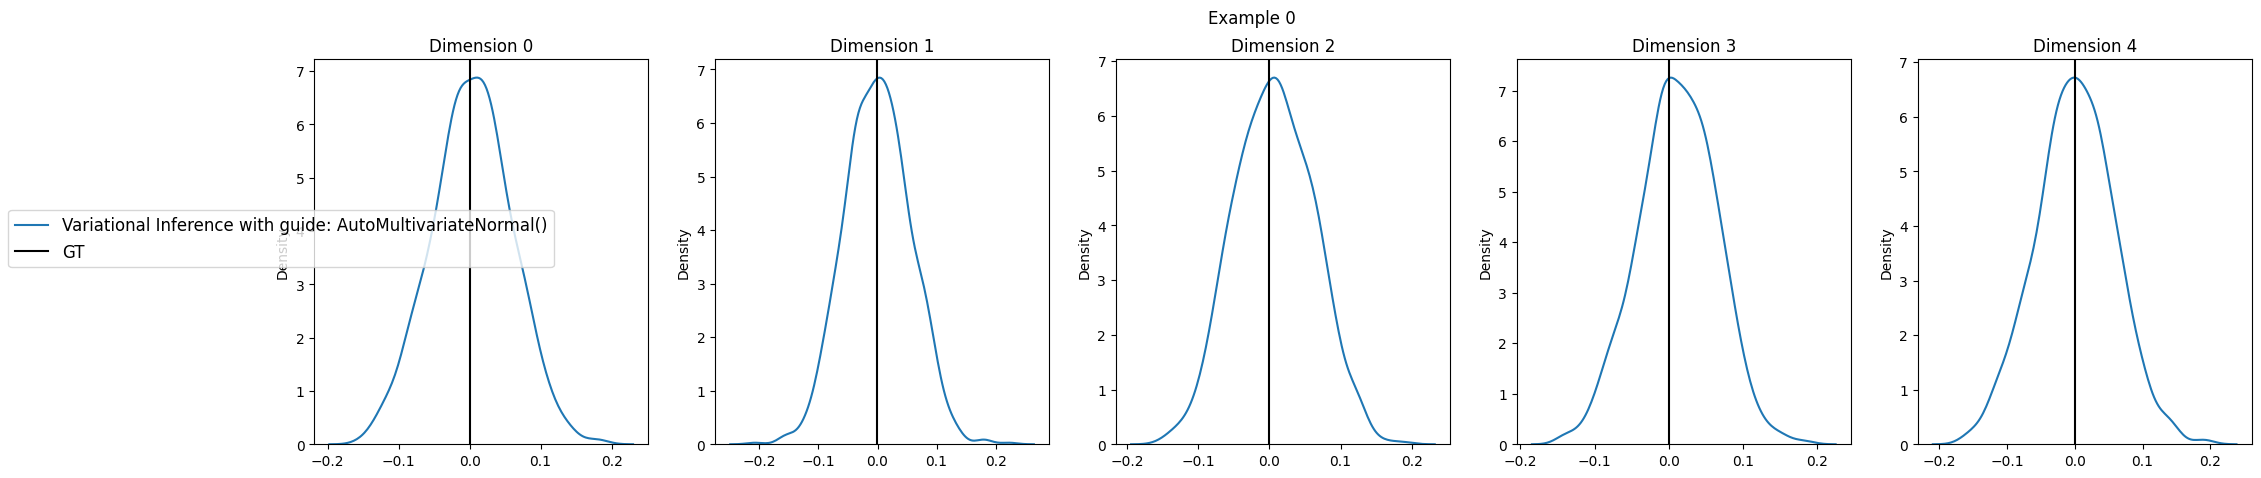

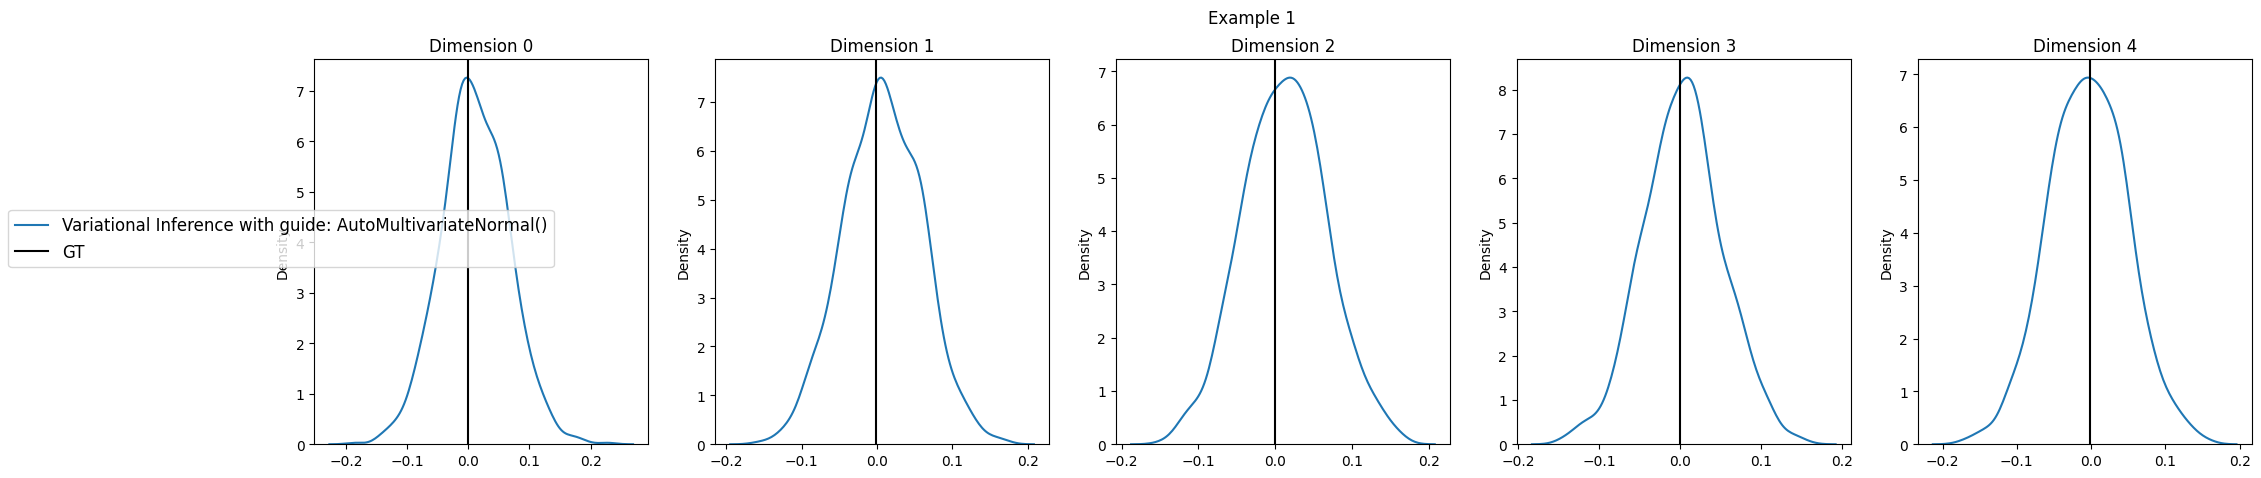

In [ ]:
evaluation.plot_results()